In [250]:
# Komplett: FP/FN-Analyse Adaptive vs. Static mit Root-Cause-Diagnose (keine Schreibzugriffe)
import pandas as pd
import numpy as np
import re
from IPython.display import display

# Pfade
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_ad_wide  = "/Users/jakob/ba_etl/adaptive/merged/all_movies_wide.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
p_st_unfil = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"

# Static Adapter-Outputs
p_st_imdb = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/ImdbAdapter.csv"
p_st_rt   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv"
p_st_mc   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MetacriticAdapter.csv"
p_st_ml   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MovielensAdapter.csv"

# Adaptive Cleaned-Quellen
p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"

id_cols = ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]
triple  = ["ID_RT","ID_METACRITIC","ID_MOVIELENS"]

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def triple_key_df(df):
    df = df.copy()
    for c in triple:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["triple_key"] = df[triple].apply(lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in triple]), axis=1)
    return df

def add_keys(df):
    df = df.copy()
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["entity_key"] = df[id_cols].apply(lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in id_cols]), axis=1)
    df = triple_key_df(df)  # wichtig: Rückgabewert übernehmen
    return df

def count_ratings_like(df, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].notna().sum(axis=1) if cols else pd.Series(0, index=df.index)

def in_set(v, S):
    return (pd.notna(v) and v in S)

# Laden + vorbereiten
ad_final = add_keys(pd.read_csv(p_ad_final, dtype=str))
ad_wide  = add_keys(pd.read_csv(p_ad_wide,  dtype=str))
st_final = add_keys(pd.read_csv(p_st_final, dtype=str))
st_unfil = add_keys(pd.read_csv(p_st_unfil, dtype=str))

# FP/FN
ad_keys = set(ad_final["entity_key"])
st_keys = set(st_final["entity_key"])
tp = ad_keys & st_keys
fp = ad_final[ad_final["entity_key"].isin(ad_keys - st_keys)].copy()
fn = st_final[st_final["entity_key"].isin(st_keys - ad_keys)].copy()

print(f"TP={len(tp)} | FP={len(fp)} | FN={len(fn)}")

# Quellen-Sets (Static/Adaptive)
st_imdb_ids = set(pd.read_csv(p_st_imdb, dtype=str)["ID_IMDB"].map(clean_id).dropna())
st_rt_ids   = set(pd.read_csv(p_st_rt,   dtype=str)["ID_RT"].map(clean_id).dropna())
st_mc_ids   = set(pd.read_csv(p_st_mc,   dtype=str)["ID_METACRITIC"].map(clean_id).dropna())
st_ml_ids   = set(pd.read_csv(p_st_ml,   dtype=str)["ID_MOVIELENS"].map(clean_id).dropna())

ad_imdb_ids = set(pd.read_csv(p_ad_imdb, dtype=str)["ID"].map(clean_id).dropna())
ad_rt_ids   = set(pd.read_csv(p_ad_rt,   dtype=str)["ID"].map(clean_id).dropna())
ad_mc_ids   = set(pd.read_csv(p_ad_mc,   dtype=str)["ID"].map(clean_id).dropna())
ad_ml_ids   = set(pd.read_csv(p_ad_ml,   dtype=str)["ID"].map(clean_id).dropna())

# Sets der Triple Keys aus "früheren" Stadien
ad_wide_triples  = set(ad_wide["triple_key"])
st_unfil_triples = set(st_unfil["triple_key"])

# Root-Cause-Funktionen
def diag_fn(row):
    tk = row["triple_key"]
    reasons = []
    if tk in ad_wide_triples:
        aw = ad_wide.loc[ad_wide["triple_key"] == tk].iloc[0]
        aw_count = int(count_ratings_like(ad_wide.loc[[aw.name]], ["rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"]).iloc[0])
        reasons.append(f"adaptive_filtered_or_postmerge_change(count_ratings={aw_count})")
        if pd.notna(row["ID_IMDB"]) and pd.notna(aw["ID_IMDB"]) and row["ID_IMDB"] != aw["ID_IMDB"]:
            reasons.append("imdb_conflict_static_vs_adaptive")
    else:
        miss = []
        if not in_set(row["ID_RT"], ad_rt_ids): miss.append("RT")
        if not in_set(row["ID_METACRITIC"], ad_mc_ids): miss.append("MC")
        if not in_set(row["ID_MOVIELENS"], ad_ml_ids): miss.append("ML")
        reasons.append(("adaptive_source_missing:" + ",".join(miss)) if miss else "adaptive_merge_failed_or_id_mismatch")
    return ";".join(reasons)

def diag_fp(row):
    tk = row["triple_key"]
    reasons = []
    if tk in st_unfil_triples:
        su = st_unfil.loc[st_unfil["triple_key"] == tk].iloc[0]
        su_count = int(count_ratings_like(st_unfil.loc[[su.name]], ["rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"]).iloc[0])
        reasons.append(f"static_filtered_or_postmerge_change(count_ratings={su_count})")
        if pd.notna(row["ID_IMDB"]) and pd.notna(su["ID_IMDB"]) and row["ID_IMDB"] != su["ID_IMDB"]:
            reasons.append("imdb_conflict_adaptive_vs_static")
    else:
        miss = []
        if not in_set(row["ID_RT"], st_rt_ids): miss.append("RT")
        if not in_set(row["ID_METACRITIC"], st_mc_ids): miss.append("MC")
        if not in_set(row["ID_MOVIELENS"], st_ml_ids): miss.append("ML")
        reasons.append(("static_source_missing:" + ",".join(miss)) if miss else "static_merge_failed_or_id_mismatch")
    return ";".join(reasons)

fn["root_cause"] = fn.apply(diag_fn, axis=1)
fp["root_cause"] = fp.apply(diag_fp, axis=1)

print("\nFN – Ursachen (Top):")
display(fn["root_cause"].value_counts().head(10))
print("\nFP – Ursachen (Top):")
display(fp["root_cause"].value_counts().head(10))

# Beispiele je Hauptursache
def show_examples(df, cause, n=8, cols=None):
    if cols is None:
        cols = ["title","release_year","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","root_cause"]
    sel = df[df["root_cause"].str.contains(cause, na=False)].head(n)
    display(sel[cols] if not sel.empty else pd.DataFrame(columns=cols))

print("\nBeispiele – FN: adaptive_filtered_or_postmerge_change")
show_examples(fn, "adaptive_filtered_or_postmerge_change")
print("\nBeispiele – FN: adaptive_source_missing")
show_examples(fn, "adaptive_source_missing")
print("\nBeispiele – FN: adaptive_merge_failed_or_id_mismatch")
show_examples(fn, "adaptive_merge_failed_or_id_mismatch")

print("\nBeispiele – FP: static_filtered_or_postmerge_change")
show_examples(fp, "static_filtered_or_postmerge_change")
print("\nBeispiele – FP: static_source_missing")
show_examples(fp, "static_source_missing")
print("\nBeispiele – FP: static_merge_failed_or_id_mismatch")
show_examples(fp, "static_merge_failed_or_id_mismatch")

# Nur-IMDB-Konflikte bei gleichem Triple (symmetrisch)
def only_imdb_conflict_view():
    fn_rows, fp_rows = [], []
    for _, r in fn.iterrows():
        tk = r["triple_key"]
        hits = ad_wide[ad_wide["triple_key"] == tk]
        if not hits.empty:
            aw = hits.iloc[0]
            if pd.notna(r["ID_IMDB"]) and pd.notna(aw["ID_IMDB"]) and r["ID_IMDB"] != aw["ID_IMDB"]:
                fn_rows.append({"title_st": r["title"], "title_ad": aw["title"], "IMDB_st": r["ID_IMDB"], "IMDB_ad": aw["ID_IMDB"], "triple_key": tk})
    for _, r in fp.iterrows():
        tk = r["triple_key"]
        hits = st_unfil[st_unfil["triple_key"] == tk]
        if not hits.empty:
            su = hits.iloc[0]
            if pd.notna(r["ID_IMDB"]) and pd.notna(su["ID_IMDB"]) and r["ID_IMDB"] != su["ID_IMDB"]:
                fp_rows.append({"title_ad": r["title"], "title_st": su["title"], "IMDB_ad": r["ID_IMDB"], "IMDB_st": su["ID_IMDB"], "triple_key": tk})
    return pd.DataFrame(fn_rows), pd.DataFrame(fp_rows)

fn_imdb_only, fp_imdb_only = only_imdb_conflict_view()
print("\nNur-IMDB-Konflikte – FN:")
display(fn_imdb_only.head(10))
print("\nNur-IMDB-Konflikte – FP:")
display(fp_imdb_only.head(10))

TP=9911 | FP=1 | FN=1

FN – Ursachen (Top):


root_cause
adaptive_merge_failed_or_id_mismatch    1
Name: count, dtype: int64


FP – Ursachen (Top):


root_cause
static_filtered_or_postmerge_change(count_ratings=3)    1
Name: count, dtype: int64


Beispiele – FN: adaptive_filtered_or_postmerge_change


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Beispiele – FN: adaptive_source_missing


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Beispiele – FN: adaptive_merge_failed_or_id_mismatch


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause
3154,cry_wolf,2005,<NA>,5034,651,5970,adaptive_merge_failed_or_id_mismatch



Beispiele – FP: static_filtered_or_postmerge_change


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause
1938,crywolf,2005,<NA>,<NA>,651,5970,static_filtered_or_postmerge_change(count_rati...



Beispiele – FP: static_source_missing


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Beispiele – FP: static_merge_failed_or_id_mismatch


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,root_cause



Nur-IMDB-Konflikte – FN:


""



Nur-IMDB-Konflikte – FP:


""


In [248]:
import pandas as pd
import re
from IPython.display import display

# Dateien
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_ad_wide  = "/Users/jakob/ba_etl/adaptive/merged/all_movies_wide.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"
p_st_unfil = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"

p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"

def clean_id(x):
    if pd.isna(x) or x == "": return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def add_keys(df):
    df = df.copy()
    for c in ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]:
        if c not in df.columns: df[c] = pd.NA
        df[c] = df[c].map(clean_id).astype("string")
    if not "title_join" in df.columns:
        df["title_join"] = ""
    df["triple_key"] = df[["ID_RT","ID_METACRITIC","ID_MOVIELENS"]].apply(
        lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in ["ID_RT","ID_METACRITIC","ID_MOVIELENS"]]), axis=1
    )
    return df

# Laden
ad_final = add_keys(pd.read_csv(p_ad_final, dtype=str))
ad_wide  = add_keys(pd.read_csv(p_ad_wide,  dtype=str))
st_final = add_keys(pd.read_csv(p_st_final, dtype=str))
st_unfil = add_keys(pd.read_csv(p_st_unfil, dtype=str))

imdb_ad = pd.read_csv(p_ad_imdb, dtype=str).assign(source="IMDB")
rt_ad   = pd.read_csv(p_ad_rt,   dtype=str).assign(source="RT")
mc_ad   = pd.read_csv(p_ad_mc,   dtype=str).assign(source="MC")
ml_ad   = pd.read_csv(p_ad_ml,   dtype=str).assign(source="ML")

# Kandidaten durch Stichwörter
pat = re.compile(r"\b(alien|predator|avp)\b", re.I)

def contains_kw(s): return bool(pat.search(str(s)))

src_titles = (
    pd.concat([
        imdb_ad.rename(columns={"ID":"ID_IMDB"})[["ID_IMDB","title","release_year","source"]],
        rt_ad.rename(columns={"ID":"ID_RT"})[["ID_RT","title","release_year","source"]],
        mc_ad.rename(columns={"ID":"ID_METACRITIC"})[["ID_METACRITIC","title","release_year","source"]],
        ml_ad.rename(columns={"ID":"ID_MOVIELENS"})[["ID_MOVIELENS","title","release_year","source"]],
    ], ignore_index=True)
    .query("title.apply(@contains_kw)")
)

print("Adaptive Quellen mit Schlüsselwörtern:")
display(src_titles.head(20))

# Finde alle Triples in Adaptive/Static, deren Titel die Keywords haben
def pick_cols(df):
    cols = ["title","title_join","release_year","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS","triple_key"]
    return [c for c in cols if c in df.columns]

ad_wide_hit  = ad_wide[ad_wide["title"].apply(contains_kw)]
ad_final_hit = ad_final[ad_final["title"].apply(contains_kw)]
st_unfil_hit = st_unfil[st_unfil["title"].apply(contains_kw)]
st_final_hit = st_final[st_final["title"].apply(contains_kw)]

print("\nAdaptive-Wide Treffer:")
display(ad_wide_hit[pick_cols(ad_wide_hit)].head(10))
print("\nAdaptive-Final Treffer:")
display(ad_final_hit[pick_cols(ad_final_hit)].head(10))
print("\nStatic-Unfiltered Treffer:")
display(st_unfil_hit[pick_cols(st_unfil_hit)].head(10))
print("\nStatic-Final Treffer:")
display(st_final_hit[pick_cols(st_final_hit)].head(10))

# Join über triple_key für direkte Gegenüberstellung (zeigt, ob Titel von anderer Quelle übernommen wurde)
cmp = (
    ad_wide_hit.merge(st_unfil_hit, on="triple_key", suffixes=("_adwide","_stwide"))
               .merge(ad_final_hit[["triple_key","title","title_join"]].rename(columns={"title":"title_adfinal","title_join":"title_join_adfinal"}), on="triple_key", how="left")
               .merge(st_final_hit[["triple_key","title","title_join"]].rename(columns={"title":"title_stfinal","title_join":"title_join_stfinal"}), on="triple_key", how="left")
)

def has_avp(s): return "avp" in str(s).lower()

if not cmp.empty:
    cmp_view = cmp[[
        "triple_key",
        "title_adwide","title_join_adwide","title_stwide","title_join_stwide",
        "title_adfinal","title_stfinal"
    ]].rename(columns={"title_join_adwide":"tj_adwide","title_join_stwide":"tj_stwide"})
    print("\nGegenüberstellung pro Triple (zeigt, wo 'avp' evtl. verloren ging):")
    display(cmp_view.head(10))

    # Kurzes Fazit je Triple
    def classify(row):
        t_adw, t_stw, t_adf, t_stf = row["title_adwide"], row["title_stwide"], row["title_adfinal"], row["title_stfinal"]
        avp_adw = has_avp(t_adw); avp_stw = has_avp(t_stw); avp_adf = has_avp(t_adf); avp_stf = has_avp(t_stf)
        if avp_adw and not avp_adf:
            return "Adaptive hat im Final 'avp' verloren (Canonical Title geändert)"
        if avp_stw and not avp_stf:
            return "Static hat im Final 'avp' verloren (Filter/Kanonisierung)"
        if avp_adw and avp_adf:
            return "Adaptive behält 'avp'"
        return "ohne avp in beiden/mehrdeutig"
    cmp_view["diagnose"] = cmp_view.apply(classify, axis=1)
    print("\nDiagnose:")
    display(cmp_view[["triple_key","diagnose"]].head(10))
else:
    print("\nKein gemeinsames Triple mit den Stichwörtern gefunden – verfeinere ggf. den Filter oben.")

Adaptive Quellen mit Schlüsselwörtern:


,ID_IMDB,title,release_year,source,ID_RT,ID_METACRITIC,ID_MOVIELENS
78,79,alien,1979,IMDB,NaN,NaN,NaN
269,270,predator,1987,IMDB,NaN,NaN,NaN
371,372,predator 2,1990,IMDB,NaN,NaN,NaN
654,657,alien resurrection,1997,IMDB,NaN,NaN,NaN
1367,1372,avp alien vs predator,2004,IMDB,NaN,NaN,NaN
1761,1766,avpr aliens vs predator requiem,2007,IMDB,NaN,NaN,NaN
2793,2798,alien covenant,2017,IMDB,NaN,NaN,NaN
3021,3027,the predator,2018,IMDB,NaN,NaN,NaN
5827,NaN,alien,1979,RT,2493,NaN,NaN
5828,NaN,alien autopsy,2006,RT,2494,NaN,NaN



Adaptive-Wide Treffer:


,title,title_join,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
383,alien,alien,1979,79,2493,8516,915,2493|8516|915
384,alien abduction,alien abduction,2014,<NA>,2496,5770,<NA>,2496|5770|NA
385,alien covenant,alien covenant,2017,2798,2497,6223,9468,2497|6223|9468
386,alien nation,alien nation,1988,<NA>,2498,<NA>,2760,2498|NA|2760
387,alien outpost,alien outpost,2015,<NA>,2499,2012,<NA>,2499|2012|NA
388,alien resurrection,alien resurrection,1997,657,2501,6992,1275,2501|6992|1275
389,alien trespass,alien trespass,2009,<NA>,2502,3444,<NA>,2502|3444|NA
699,avp alien vs predator,avp alien vs predator,2004,<NA>,2503,1797,5302,2503|1797|5302
700,avpr aliens vs predator requiem,avpr aliens vs predator requiem,2007,<NA>,<NA>,3274,6634,NA|3274|6634
4983,my stepmother is an alien,my stepmother is an alien,1988,<NA>,10864,<NA>,3338,10864|NA|3338



Adaptive-Final Treffer:


,title,title_join,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
427,alien,,1979,79,2493,8516,915,2493|8516|915
428,alien abduction,,2014,<NA>,2496,5770,<NA>,2496|5770|NA
429,alien covenant,,2017,2798,2497,6223,9468,2497|6223|9468
430,alien nation,,1988,<NA>,2498,<NA>,2760,2498|NA|2760
431,alien outpost,,2015,<NA>,2499,2012,<NA>,2499|2012|NA
432,alien resurrection,,1997,657,2501,6992,1275,2501|6992|1275
433,alien trespass,,2009,<NA>,2502,3444,<NA>,2502|3444|NA
767,avp alien vs predator,,2004,1372,2503,1797,5302,2503|1797|5302
768,avpr aliens vs predator requiem,,2007,1766,<NA>,3274,6634,NA|3274|6634
5377,my stepmother is an alien,,1988,<NA>,10864,<NA>,3338,10864|NA|3338



Static-Unfiltered Treffer:


,title,title_join,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
999,alien,,79,<NA>,8516,915,NA|8516|915
1000,alien 3,,<NA>,<NA>,7369,<NA>,NA|7369|NA
1001,alien abduction,,<NA>,<NA>,5770,<NA>,NA|5770|NA
1002,alien autopsy,,<NA>,<NA>,<NA>,<NA>,NA|NA|NA
1003,alien contamination,,<NA>,<NA>,<NA>,4589,NA|NA|4589
1004,alien covenant,,2798,<NA>,6223,9468,NA|6223|9468
1005,alien from l a,,<NA>,<NA>,<NA>,4623,NA|NA|4623
1006,alien nation,,<NA>,<NA>,<NA>,2760,NA|NA|2760
1007,alien outpost,,<NA>,<NA>,2012,<NA>,NA|2012|NA
1008,alien raiders,,<NA>,<NA>,<NA>,<NA>,NA|NA|NA



Static-Final Treffer:


,title,title_join,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,triple_key
25,alien covenant,,2017,2798,2497,6223,9468,2497|6223|9468
1132,avp alien vs predator,,2004,1372,2503,1797,5302,2503|1797|5302
1555,alien resurrection,,1997,657,2501,6992,1275,2501|6992|1275
1770,predator 2,,1990,372,12004,1967,2756,12004|1967|2756
1832,predator,,1987,270,12003,790,2633,12003|790|2633
1929,alien,,1979,79,2493,8516,915,2493|8516|915
2093,the predator,,2018,3027,15647,7333,<NA>,15647|7333|NA
2942,avpr aliens vs predator requiem,,2007,1766,<NA>,3274,6634,NA|3274|6634
5424,alien outpost,,2015,<NA>,2499,2012,<NA>,2499|2012|NA
5681,alien abduction,,2014,<NA>,2496,5770,<NA>,2496|5770|NA



Gegenüberstellung pro Triple (zeigt, wo 'avp' evtl. verloren ging):


,triple_key,title_adwide,tj_adwide,title_stwide,tj_stwide,title_adfinal,title_stfinal
0,NA|3274|6634,avpr aliens vs predator requiem,avpr aliens vs predator requiem,avpr aliens vs predator requiem,,avpr aliens vs predator requiem,avpr aliens vs predator requiem



Diagnose:


,triple_key,diagnose
0,NA|3274|6634,Adaptive behält 'avp'


In [1]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
from IPython.display import display

# Cleaned-Quellen (Adaptive)
p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"

CANON = {
    "imdb_data":              "rating_imdb",
    "movielens_aggregated":   "rating_movielens",
    "metacritic_movies":      "rating_metacritic",
    "rotten_tomatoes_movies": "rating_rt_audience",
}

ID_MAP = {
    "imdb_data":              "ID_IMDB",
    "movielens_aggregated":   "ID_MOVIELENS",
    "metacritic_movies":      "ID_METACRITIC",
    "rotten_tomatoes_movies": "ID_RT",
}

def standardize_id_column(df: pd.DataFrame, src: str) -> pd.DataFrame:
    target = ID_MAP.get(src, f"ID_{src.upper()}")
    if target in df.columns:
        pass
    elif "ID" in df.columns:
        df = df.rename(columns={"ID": target})
    else:
        cands = [c for c in df.columns if str(c).upper().startswith("ID_")]
        if cands:
            df = df.rename(columns={cands[0]: target})
    if target in df.columns:
        df[target] = pd.to_numeric(df[target], errors="coerce").astype("Int64")
    return df

def norm_title(title: str) -> str:
    if not isinstance(title, str):
        return ""
    t = unidecode(title).lower()
    t = re.sub(r"\s*\(\d{4}\)$", "", t)      # (YYYY) am Ende
    t = re.sub(r"\s*\([^)]*\)$", "", t)      # alias/aka am Ende
    t = re.sub(r"[^\w\s]", " ", t)           # Satzzeichen → Leerzeichen
    t = re.sub(r"\bthe\s*$", "", t)          # trailing "the"
    t = re.sub(r"\s+", " ", t).strip()
    # doppelte Tokens entfernen (behält 'avp' als eigenes Token!)
    seen, out = set(), []
    for tok in t.split():
        if tok not in seen:
            out.append(tok); seen.add(tok)
    return " ".join(out)

def year_cluster(sub: pd.DataFrame) -> pd.Series:
    years = sorted(set([y for y in sub["release_year"].dropna()]))
    clusters, cid = {}, 0
    for y in years:
        if any(abs(y - c) <= 1 for c in clusters.get(cid, [])):
            clusters[cid].append(y)
        else:
            cid += 1; clusters[cid] = [y]
    mapping = {y: c for c, ys in clusters.items() for y in ys}
    return sub["release_year"].map(mapping).fillna(cid + 1).astype(int)

# 1) Cleaned laden und wie im Notebook vorbereiten
frames = []
for src, p in [
    ("imdb_data", p_ad_imdb),
    ("movielens_aggregated", p_ad_ml),
    ("metacritic_movies", p_ad_mc),
    ("rotten_tomatoes_movies", p_ad_rt),
]:
    df = pd.read_csv(p)
    if "year" in df.columns and "release_year" not in df.columns:
        df = df.rename(columns={"year": "release_year"})
    rating_col = CANON.get(src, f"rating_{src}")
    if "rating" in df.columns and rating_col not in df.columns:
        df = df.rename(columns={"rating": rating_col})
    df = standardize_id_column(df, src)
    df["source"] = src
    frames.append(df)

long_df = pd.concat(frames, ignore_index=True)
long_df["release_year"] = pd.to_numeric(long_df["release_year"], errors="coerce").astype("Int64")
long_df["norm_title"]   = long_df["title"].map(norm_title)
long_df["year_cluster"] = long_df.groupby("norm_title", group_keys=False).apply(year_cluster)

group_cols   = ["norm_title", "year_cluster"]
rating_cols  = [c for c in long_df.columns if c.startswith("rating_")]
id_cols      = [c for c in long_df.columns if str(c).startswith("ID_")]

def first_valid(s: pd.Series):
    s = s.dropna()
    return s.iloc[0] if not s.empty else np.nan

def first_non_empty(series: pd.Series):
    for val in series:
        if isinstance(val, list) and val:
            return val
        if isinstance(val, str) and val.strip():
            return val
    return np.nan

ratings_wide = long_df.groupby(group_cols, as_index=False)[rating_cols].agg(first_valid) if rating_cols else long_df[group_cols].drop_duplicates()
ids_map      = long_df.groupby(group_cols, as_index=False)[id_cols].agg(first_valid)     if id_cols     else long_df[group_cols].drop_duplicates()
meta = (long_df.sort_values(["source", "title"])
               .groupby(group_cols, as_index=False)
               .agg(title=("title","first"), release_year=("release_year","min")))

wide = ratings_wide.merge(meta, on=group_cols, how="left").merge(ids_map, on=group_cols, how="left")

# 2) Zeige für alle relevanten Gruppen (Alien/Predator/AVP) die Quell-Titel + den gewählten Kanon-Titel
pat = re.compile(r"\b(alien|predator|avp)\b", re.I)
cand_groups = long_df.loc[long_df["title"].str.contains(pat)].drop_duplicates(subset=group_cols)[group_cols]

def group_view(gkey):
    nt, yc = gkey["norm_title"], gkey["year_cluster"]
    sub = long_df[(long_df["norm_title"]==nt) & (long_df["year_cluster"]==yc)][["source","title","release_year"]].sort_values(["source","title"])
    chosen = wide[(wide["norm_title"]==nt) & (wide["year_cluster"]==yc)][["title","release_year"]].iloc[0]
    print(f"\nGruppe: norm_title='{nt}' | year_cluster={yc}")
    print("Quell-Titel (sorted by source,title):")
    display(sub.reset_index(drop=True))
    print("Gewählter Kanon-Titel (meta first(source,title)):")
    display(chosen.to_frame().T)

cand_groups.apply(group_view, axis=1);

print("\nHinweis: Wenn der IMDB-Titel 'AVP: Alien vs Predator' in derselben Gruppe steht wie ein RT/MC/ML-Titel 'Alien vs Predator', kann der gewählte Titel ohne 'AVP' stammen, weil die Auswahl über first(source,title) erfolgt. 'norm_title' dient nur zum Gruppieren; der ausgegebene 'title' ist ein unveränderter Originaltitel aus der (nach source,title) ersten Zeile.")

/var/folders/1d/r43xvhb549d6dky2tk41bsjw0000gn/T/ipykernel_79690/846727589.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_df["year_cluster"] = long_df.groupby("norm_title", group_keys=False).apply(year_cluster)



Gruppe: norm_title='alien' | year_cluster=1
Quell-Titel (sorted by source,title):


/var/folders/1d/r43xvhb549d6dky2tk41bsjw0000gn/T/ipykernel_79690/846727589.py:117: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cand_groups = long_df.loc[long_df["title"].str.contains(pat)].drop_duplicates(subset=group_cols)[group_cols]


,source,title,release_year
0,imdb_data,alien,1979
1,metacritic_movies,alien,1979
2,movielens_aggregated,alien,1979
3,rotten_tomatoes_movies,alien,1979


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
999,alien,1979



Gruppe: norm_title='predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,predator,1987
1,metacritic_movies,predator,1987
2,movielens_aggregated,predator,1987
3,rotten_tomatoes_movies,predator,1987


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
14158,predator,1987



Gruppe: norm_title='predator 2' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,predator 2,1990
1,metacritic_movies,predator 2,1990
2,movielens_aggregated,predator 2,1990
3,rotten_tomatoes_movies,predator 2,1990


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
14159,predator 2,1990



Gruppe: norm_title='alien resurrection' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,alien resurrection,1997
1,metacritic_movies,alien resurrection,1997
2,movielens_aggregated,alien resurrection,1997
3,rotten_tomatoes_movies,alien resurrection,1997


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1009,alien resurrection,1997



Gruppe: norm_title='avp alien vs predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,avp alien vs predator,2004
1,metacritic_movies,avp alien vs predator,2004
2,movielens_aggregated,avp alien vs predator,2004
3,rotten_tomatoes_movies,avp alien vs predator,2004


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1787,avp alien vs predator,2004



Gruppe: norm_title='avpr aliens vs predator requiem' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,avpr aliens vs predator requiem,2007
1,metacritic_movies,avpr aliens vs predator requiem,2007
2,movielens_aggregated,avpr aliens vs predator requiem,2007


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1788,avpr aliens vs predator requiem,2007



Gruppe: norm_title='alien covenant' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,alien covenant,2017
1,metacritic_movies,alien covenant,2017
2,movielens_aggregated,alien covenant,2017
3,rotten_tomatoes_movies,alien covenant,2017


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1004,alien covenant,2017



Gruppe: norm_title='the predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,imdb_data,the predator,2018
1,metacritic_movies,the predator,2018
2,rotten_tomatoes_movies,the predator,2018


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
20055,the predator,2018



Gruppe: norm_title='alien nation' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,alien nation,1988
1,rotten_tomatoes_movies,alien nation,1988


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1006,alien nation,1988



Gruppe: norm_title='my stepmother is an alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,my stepmother is an alien,1988
1,rotten_tomatoes_movies,my stepmother is an alien,1988


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
12519,my stepmother is an alien,1988



Gruppe: norm_title='without warning a k alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,without warning a k alien,1980


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
22968,without warning a k alien,1980



Gruppe: norm_title='alien contamination' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,alien contamination,1980


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1003,alien contamination,1980



Gruppe: norm_title='alien from l a' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,alien from l a,1988


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1005,alien from l a,1988



Gruppe: norm_title='codependent lesbian space alien seeks same' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,movielens_aggregated,codependent lesbian space alien seeks same,2011


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
4127,codependent lesbian space alien seeks same,2011



Gruppe: norm_title='alien outpost' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien outpost,2015
1,rotten_tomatoes_movies,alien outpost,2015


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1007,alien outpost,2015



Gruppe: norm_title='alien trespass' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien trespass,2009
1,rotten_tomatoes_movies,alien trespass,2009


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1010,alien trespass,2009



Gruppe: norm_title='alien abduction' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien abduction,2014
1,rotten_tomatoes_movies,alien abduction,2014


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1001,alien abduction,2014



Gruppe: norm_title='alien 3' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,metacritic_movies,alien 3,1992


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1000,alien 3,1992



Gruppe: norm_title='alien autopsy' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,alien autopsy,2006


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1002,alien autopsy,2006



Gruppe: norm_title='alien raiders' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,alien raiders,2016


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1008,alien raiders,2016



Gruppe: norm_title='aliens vs predator requiem' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,aliens vs predator requiem,2007


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
1015,aliens vs predator requiem,2007



Gruppe: norm_title='bikram yogi guru predator' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,bikram yogi guru predator,2019


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
2500,bikram yogi guru predator,2019



Gruppe: norm_title='memory the origins of alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,memory the origins of alien,2019


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
11750,memory the origins of alien,2019



Gruppe: norm_title='phil the alien' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,phil the alien,2004


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
13855,phil the alien,2004



Gruppe: norm_title='scooby doo and the alien invaders' | year_cluster=1
Quell-Titel (sorted by source,title):


,source,title,release_year
0,rotten_tomatoes_movies,scooby doo and the alien invaders,2008


Gewählter Kanon-Titel (meta first(source,title)):


,title,release_year
15461,scooby doo and the alien invaders,2008



Hinweis: Wenn der IMDB-Titel 'AVP: Alien vs Predator' in derselben Gruppe steht wie ein RT/MC/ML-Titel 'Alien vs Predator', kann der gewählte Titel ohne 'AVP' stammen, weil die Auswahl über first(source,title) erfolgt. 'norm_title' dient nur zum Gruppieren; der ausgegebene 'title' ist ein unveränderter Originaltitel aus der (nach source,title) ersten Zeile.


Gesamt (entity_key): TP=9911  FP=1  FN=1
Precision=0.9999  Recall=0.9999  F1=0.9999  Jaccard=0.9998


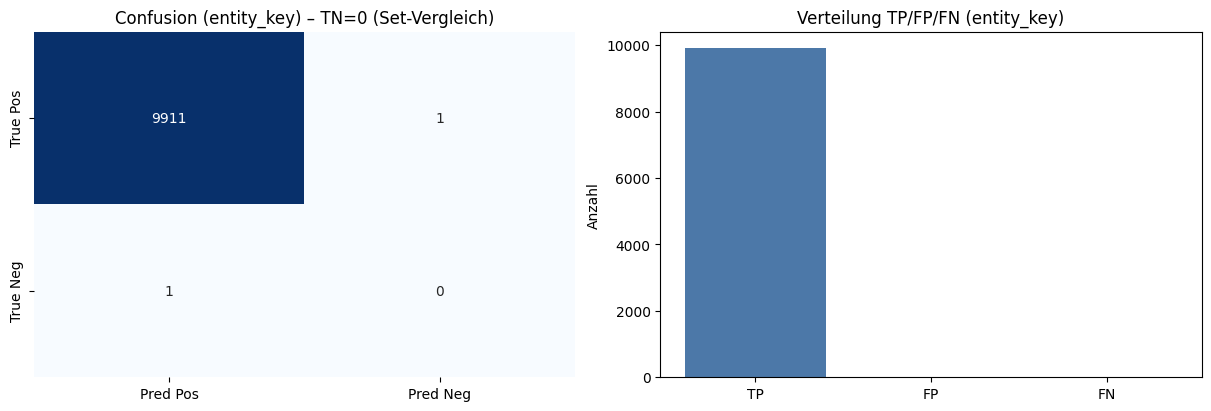

Beispiele FP (nur Adaptive):


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS
1938,cry wolf,2005,<NA>,5034,651,<NA>


Beispiele FN (nur Groundtruth):


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS
3154,cry_wolf,2005,<NA>,5034,651,5970



Metriken je ID-Quelle:


,source_id,tp,fp,fn,precision,recall,f1,jaccard
0,ID_IMDB,3012.0,0.0,0.0,1.0,1.0000,1.0000,1.0000
1,ID_RT,9542.0,0.0,0.0,1.0,1.0000,1.0000,1.0000
2,ID_METACRITIC,7848.0,0.0,0.0,1.0,1.0000,1.0000,1.0000
3,ID_MOVIELENS,5838.0,0.0,1.0,1.0,0.9998,0.9999,0.9998


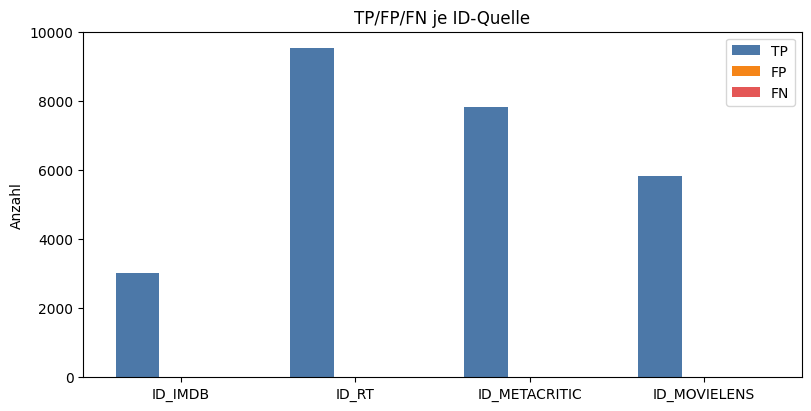


Übersicht (Overall + je Quelle):


,scope,tp,fp,fn,precision,recall,f1,jaccard
0,entity_key_overall,9911,1,1,0.9999,0.9999,0.9999,0.9998
1,ID_IMDB,3012,0,0,1.0000,1.0000,1.0000,1.0000
2,ID_RT,9542,0,0,1.0000,1.0000,1.0000,1.0000
3,ID_METACRITIC,7848,0,0,1.0000,1.0000,1.0000,1.0000
4,ID_MOVIELENS,5838,0,1,1.0000,0.9998,0.9999,0.9998


In [4]:
# ID-basierte Confusion-/Metrik-Analyse + Visualisierung (keine Schreibzugriffe)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# Pfade
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

id_cols = ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]

def clean_id(x):
    if pd.isna(x) or x == "":
        return pd.NA
    s = str(x).strip()
    return s[:-2] if s.endswith(".0") else s

def add_entity_key(df):
    df = df.copy()
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        df[c] = df[c].apply(clean_id).astype("string")
    df["entity_key"] = df[id_cols].apply(lambda r: "|".join([(r[c] if pd.notna(r[c]) else "NA") for c in id_cols]), axis=1)
    return df

# Laden + Keys
ad = add_entity_key(pd.read_csv(p_ad_final, dtype=str))
st = add_entity_key(pd.read_csv(p_st_final, dtype=str))

# Set-Vergleich overall (entity_key)
ad_keys = set(ad["entity_key"])
st_keys = set(st["entity_key"])

tp_keys = ad_keys & st_keys
fp_keys = ad_keys - st_keys
fn_keys = st_keys - ad_keys

TP = len(tp_keys)
FP = len(fp_keys)
FN = len(fn_keys)
TN = 0  # für Set-Vergleich nicht definiert – 0 zur Visualisierung

def metrics(tp, fp, fn):
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall    = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1        = 2*precision*recall/(precision+recall) if precision+recall > 0 else 0.0
    jaccard   = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
    return dict(precision=precision, recall=recall, f1=f1, jaccard=jaccard)

overall = metrics(TP, FP, FN)

print(f"Gesamt (entity_key): TP={TP}  FP={FP}  FN={FN}")
print(f"Precision={overall['precision']:.4f}  Recall={overall['recall']:.4f}  F1={overall['f1']:.4f}  Jaccard={overall['jaccard']:.4f}")

# Confusion-"Matrix" (2x2, TN=0 mangels Universum)
cm = np.array([[TP, FN],
               [FP, TN]], dtype=int)
labels = [["TP","FN"],["FP","TN"]]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
if HAS_SNS:
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax[0],
                xticklabels=["Pred Pos","Pred Neg"], yticklabels=["True Pos","True Neg"])
else:
    im = ax[0].imshow(cm, cmap="Blues")
    for (i,j), v in np.ndenumerate(cm):
        ax[0].text(j, i, str(v), ha="center", va="center", color="black")
    ax[0].set_xticks([0,1]); ax[0].set_xticklabels(["Pred Pos","Pred Neg"])
    ax[0].set_yticks([0,1]); ax[0].set_yticklabels(["True Pos","True Neg"])
ax[0].set_title("Confusion (entity_key) – TN=0 (Set-Vergleich)")

# Balken: TP/FP/FN
ax[1].bar(["TP","FP","FN"], [TP, FP, FN], color=["#4c78a8","#f58518","#e45756"])
ax[1].set_title("Verteilung TP/FP/FN (entity_key)")
ax[1].set_ylabel("Anzahl")
plt.show()

# Tabellen für FP / FN Beispiele
from IPython.display import display
fp = ad[ad["entity_key"].isin(fp_keys)][["title","release_year"] + id_cols].head(10)
fn = st[st["entity_key"].isin(fn_keys)][["title","release_year"] + id_cols].head(10)
print("Beispiele FP (nur Adaptive):")
display(fp)
print("Beispiele FN (nur Groundtruth):")
display(fn)

# Per-ID-Quelle: Mengenvergleich und Metriken
def per_source_sets(df, col):
    return set(df[col].dropna().astype(str))

per_src = {}
for col in id_cols:
    ad_set = per_source_sets(ad, col)
    st_set = per_source_sets(st, col)
    tp = len(ad_set & st_set)
    fp = len(ad_set - st_set)
    fn = len(st_set - ad_set)
    per_src[col] = dict(tp=tp, fp=fp, fn=fn, **metrics(tp, fp, fn))

per_src_df = (pd.DataFrame(per_src).T
              .rename_axis("source_id")
              .reset_index()
              .assign(precision=lambda d: d["precision"].round(4),
                      recall=lambda d: d["recall"].round(4),
                      f1=lambda d: d["f1"].round(4),
                      jaccard=lambda d: d["jaccard"].round(4)))
print("\nMetriken je ID-Quelle:")
display(per_src_df[["source_id","tp","fp","fn","precision","recall","f1","jaccard"]])

# Visualisierung per ID-Quelle: Balken TP/FP/FN
fig2, ax2 = plt.subplots(figsize=(8, 4), constrained_layout=True)
idx = np.arange(len(id_cols))
tp_vals = [per_src[c]["tp"] for c in id_cols]
fp_vals = [per_src[c]["fp"] for c in id_cols]
fn_vals = [per_src[c]["fn"] for c in id_cols]
width = 0.25
ax2.bar(idx - width, tp_vals, width=width, label="TP", color="#4c78a8")
ax2.bar(idx,         fp_vals, width=width, label="FP", color="#f58518")
ax2.bar(idx + width, fn_vals, width=width, label="FN", color="#e45756")
ax2.set_xticks(idx); ax2.set_xticklabels(id_cols)
ax2.set_ylabel("Anzahl"); ax2.set_title("TP/FP/FN je ID-Quelle")
ax2.legend()
plt.show()

# Kompakte Übersicht als Tabelle (Overall + je Quelle)
summary_rows = [
    dict(scope="entity_key_overall", tp=TP, fp=FP, fn=FN, **{k: round(v,4) for k,v in overall.items()})
]
for c in id_cols:
    d = per_src[c]
    summary_rows.append(dict(scope=c, tp=d["tp"], fp=d["fp"], fn=d["fn"],
                             precision=round(d["precision"],4),
                             recall=round(d["recall"],4),
                             f1=round(d["f1"],4),
                             jaccard=round(d["jaccard"],4)))
summary_df = pd.DataFrame(summary_rows)
print("\nÜbersicht (Overall + je Quelle):")
display(summary_df)

TP=0 | FP=9,912 | FN=9,912

Exakte Feld‑Mismatches (nur TPs, ohne Normalisierung):


,field,num_mismatches
0,title,0
1,release_year,0
2,genres,0
3,rating_imdb,0
4,rating_metacritic,0
5,rating_movielens,0
6,rating_rt_audience,0


/var/folders/1d/r43xvhb549d6dky2tk41bsjw0000gn/T/ipykernel_15741/1367961285.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mismatch_summary["field"], rotation=30, ha="right")
/Users/jakob/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


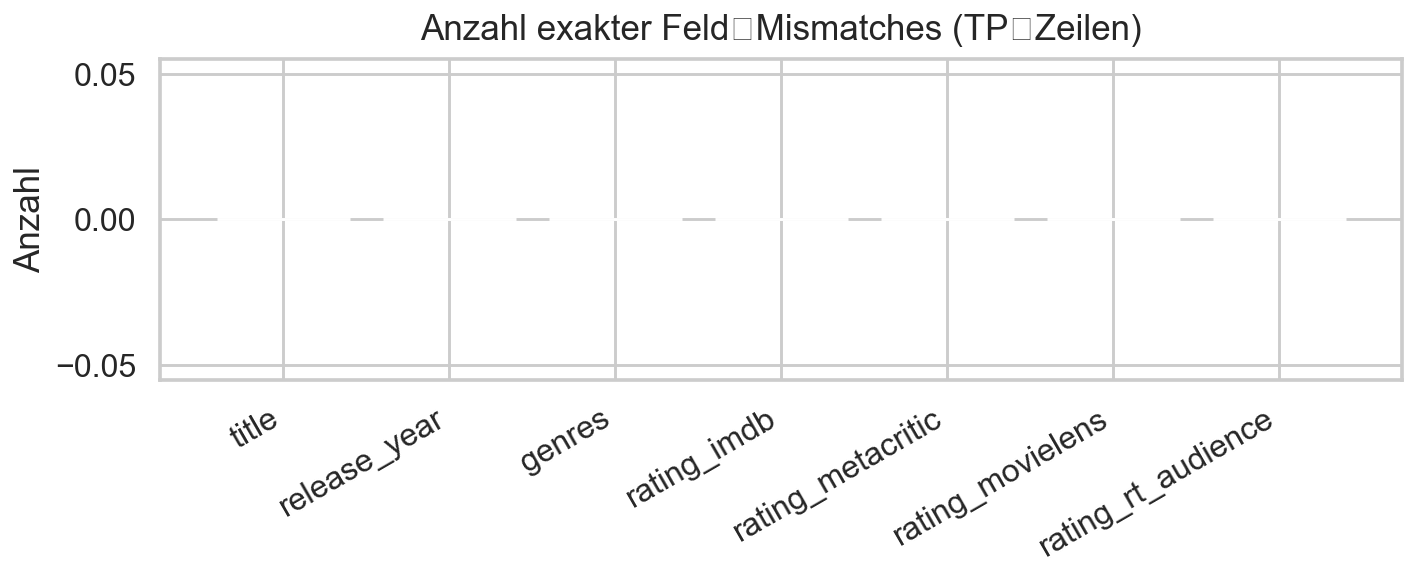


Keine numerischen Deltas > 0 (oder nicht numerisch auswertbar).

Preview: Feldvergleich (erste 10 TPs)


,entity_key,title_ad,title_st,title_eq_exact,release_year_ad,release_year_st,release_year_eq_exact,genres_ad,genres_st,genres_eq_exact,rating_imdb_ad,rating_imdb_st,rating_imdb_eq_exact,rating_metacritic_ad,rating_metacritic_st,rating_metacritic_eq_exact,rating_movielens_ad,rating_movielens_st,rating_movielens_eq_exact,rating_rt_audience_ad,rating_rt_audience_st,rating_rt_audience_eq_exact


In [252]:
# Feldweiser 1:1-Vergleich der FINALEN Sets (ohne Normalisierung)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# Pfade
p_ad_final = "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

id_cols = ["ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]

def add_entity_key_raw(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in id_cols:
        if c not in df.columns:
            df[c] = pd.NA
        # keine .0-Entfernung o.ä.: wir nehmen die raw-Strings der finalen Sets
        df[c] = df[c].astype("string")
    # fehlende als "NA" nur für den Schlüssel (ändert nicht die Felder)
    key_df = df[id_cols].astype("string").fillna("NA")
    df["entity_key"] = key_df.apply(lambda r: "|".join([r[c] for c in id_cols]), axis=1)
    return df

# Laden (raw) + Keys
ad = add_entity_key_raw(pd.read_csv(p_ad_final, dtype=str, keep_default_na=True))
st = add_entity_key_raw(pd.read_csv(p_st_final, dtype=str, keep_default_na=True))

# TP/FP/FN auf entity_key (raw)
ad_keys = set(ad["entity_key"])
st_keys = set(st["entity_key"])
tp_keys = ad_keys & st_keys
fp_keys = ad_keys - st_keys
fn_keys = st_keys - ad_keys

print(f"TP={len(tp_keys):,} | FP={len(fp_keys):,} | FN={len(fn_keys):,}")

# Nur TPs feldweise vergleichen (raw Felder)
ad_tp = ad[ad["entity_key"].isin(tp_keys)].copy()
st_tp = st[st["entity_key"].isin(tp_keys)].copy()
df = ad_tp.merge(st_tp, on="entity_key", suffixes=("_ad","_st"))

# Relevante gemeinsame Felder suchen
common_cols = sorted(set(ad.columns) & set(st.columns))
# Fokusfelder definieren (nur wenn vorhanden)
focus_base = ["title","release_year","genres"]
focus_ratings = [c for c in common_cols if c.startswith("rating_")]
focus_extra = [c for c in ["count_ratings"] if c in common_cols]
focus_cols = [c for c in focus_base + focus_ratings + focus_extra if c in common_cols]

# Exakte Feldgleichheit (Stringvergleich) für Fokusfelder
eq_rows = []
for c in focus_cols:
    a = f"{c}_ad"; b = f"{c}_st"
    if a not in df.columns or b not in df.columns:
        continue
    eq_col = f"{c}_eq_exact"
    df[eq_col] = (df[a].fillna("") == df[b].fillna(""))
    eq_rows.append((c, int((~df[eq_col]).sum())))

mismatch_summary = pd.DataFrame(eq_rows, columns=["field","num_mismatches"]).sort_values("num_mismatches", ascending=False).reset_index(drop=True)

print("\nExakte Feld‑Mismatches (nur TPs, ohne Normalisierung):")
from IPython.display import display
display(mismatch_summary)

# Beispiele je Feld mit Abweichungen
def show_examples_for_field(field, n=8):
    a = f"{field}_ad"; b = f"{field}_st"; eq = f"{field}_eq_exact"
    if eq not in df.columns:
        print(f"{field}: nicht vorhanden")
        return
    cols = ["entity_key"] + [a, b]
    sel = df.loc[~df[eq], cols].head(n)
    print(f"\nBeispiele – Abweichungen in {field} (n={len(sel)})")
    display(sel)

for field in [f for f in mismatch_summary["field"].tolist() if mismatch_summary.set_index("field").loc[f, "num_mismatches"] > 0][:6]:
    show_examples_for_field(field, n=8)

# Numerische Deltas für Felder, die numerisch sind (z. B. Ratings, release_year, count_ratings)
def to_num(x):
    v = pd.to_numeric(x, errors="coerce")
    return float(v) if pd.notna(v) else np.nan

numeric_candidates = []
for c in focus_cols:
    a = f"{c}_ad"; b = f"{c}_st"
    if a in df.columns and b in df.columns:
        # prüfe, ob mind. eine Zeile zu float konvertierbar ist
        tmp = pd.to_numeric(df[a], errors="coerce").notna() | pd.to_numeric(df[b], errors="coerce").notna()
        if bool(tmp.any()):
            numeric_candidates.append(c)

for c in numeric_candidates:
    a = f"{c}_ad"; b = f"{c}_st"
    d = f"{c}_delta"
    df[d] = df[a].map(to_num) - df[b].map(to_num)

# Plot: Mismatch‑Counts
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.bar(mismatch_summary["field"], mismatch_summary["num_mismatches"], color="#e45756")
ax.set_title("Anzahl exakter Feld‑Mismatches (TP‑Zeilen)")
ax.set_ylabel("Anzahl")
ax.set_xticklabels(mismatch_summary["field"], rotation=30, ha="right")
plt.show()

# Plot: Deltaverteilungen für numerische Felder (nur wenn Unterschiede existieren)
nz_deltas = []
for c in numeric_candidates:
    d = f"{c}_delta"
    if d in df.columns and df[d].notna().any() and (df[d].fillna(0) != 0).any():
        nz = df.loc[df[d].notna() & (df[d] != 0), d]
        nz_deltas.append((c, nz))

if nz_deltas:
    n = len(nz_deltas)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 3), constrained_layout=True)
    if n == 1:
        axs = [axs]
    for ax, (c, series) in zip(axs, nz_deltas):
        if HAS_SNS:
            sns.histplot(series, bins=30, ax=ax, color="#4c78a8")
        else:
            ax.hist(series, bins=30, color="#4c78a8")
        ax.set_title(f"{c} Δ (ad - st)")
        ax.set_xlabel("Delta")
    plt.show()
else:
    print("\nKeine numerischen Deltas > 0 (oder nicht numerisch auswertbar).")

# Kompakte Übersichtstabelle mit Gleichheits-Flaggen und optionalen Deltas (erste 10 Zeilen)
preview_cols = ["entity_key"]
for c in focus_cols:
    a = f"{c}_ad"; b = f"{c}_st"; eq = f"{c}_eq_exact"
    if a in df.columns and b in df.columns:
        preview_cols += [a, b, eq]
        d = f"{c}_delta"
        if d in df.columns:
            preview_cols.append(d)

print("\nPreview: Feldvergleich (erste 10 TPs)")
display(df[preview_cols].head(10))

In [2]:
# End-to-End-Fallanalyse per IDs: Rohquellen (Adaptive/Static) + Wide/Final (beide Pipelines)
import pandas as pd
from IPython.display import display

# === Ziel-IDs für den Film ===
ID_RT   = "5034"
ID_MC   = "651"
ID_ML   = "5970"
ID_IMDB = None  # falls bekannt, z. B. "2460"; sonst None

# === Pfade ===
# Adaptive (Cleaned + Merges)
p_ad_imdb = "/Users/jakob/ba_etl/adaptive/cleaned/imdb_data.csv"                  
p_ad_rt   = "/Users/jakob/ba_etl/adaptive/cleaned/rotten_tomatoes_movies.csv"    
p_ad_mc   = "/Users/jakob/ba_etl/adaptive/cleaned/metacritic_movies.csv"         
p_ad_ml   = "/Users/jakob/ba_etl/adaptive/cleaned/movielens_aggregated.csv"      
p_ad_wide = "/Users/jakob/ba_etl/adaptive/merged/all_movies_wide.csv"            
p_ad_final= "/Users/jakob/ba_etl/adaptive/merged/all_movies_superscore_adaptive.csv"

# Static (Adapter-Outputs + Merges)
p_st_imdb = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/ImdbAdapter.csv"           
p_st_rt   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/RottenTomatoesAdapter.csv" 
p_st_mc   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MetacriticAdapter.csv"     
p_st_ml   = "/Users/jakob/ba_etl/static_pipeline/data/intermediate_adapter_outputs/MovielensAdapter.csv"      
p_st_unfil = "/Users/jakob/ba_etl/static_pipeline/data/processed/all_movies_wide_unfiltered.csv"
p_st_final = "/Users/jakob/ba_etl/static_pipeline/data/processed/final_filtered_superscore.csv"

# === Helper ===
def load(path):
    return pd.read_csv(path, dtype=str, keep_default_na=True)

def id_variants(x):
    if x is None: return set()
    s = str(x)
    return {s, f"{s}.0"}

def match_ids(df, id_map):
    """
    id_map: dict wie {"ID_RT": {"5034","5034.0"}, ...}
    matched wenn JEDE im df vorhandene Bedingung erfüllt ist.
    Fehlende Spalten werden ignoriert.
    """
    if not id_map:
        return pd.Series([True]*len(df), index=df.index)
    mask = pd.Series([True]*len(df), index=df.index)
    for col, vals in id_map.items():
        if col in df.columns and vals:
            mask = mask & df[col].astype(str).isin(vals)
    return mask

def pick_cols(df, extra=None):
    base = ["title","release_year","year","release_date","ID_IMDB","ID_RT","ID_METACRITIC","ID_MOVIELENS"]
    if extra:
        base += extra
    return [c for c in base if c in df.columns]

def show(df, title, n=5, extra=None):
    print(title)
    if df.empty:
        print("(keine Treffer)\n")
    else:
        display(df[pick_cols(df, extra)].head(n))

# === Ziel-ID-Mengen ===
rt_vals   = id_variants(ID_RT)
mc_vals   = id_variants(ID_MC)
ml_vals   = id_variants(ID_ML)
imdb_vals = id_variants(ID_IMDB) if ID_IMDB else set()

# === 1) Rohquellen: Adaptive Cleaned ===
ad_rt_src   = load(p_ad_rt).rename(columns={"ID":"ID_RT"})
ad_mc_src   = load(p_ad_mc).rename(columns={"ID":"ID_METACRITIC"})
ad_ml_src   = load(p_ad_ml).rename(columns={"ID":"ID_MOVIELENS"})
ad_imdb_src = load(p_ad_imdb).rename(columns={"ID":"ID_IMDB"})

show(ad_rt_src[ match_ids(ad_rt_src, {"ID_RT": rt_vals}) ], "Adaptive Cleaned – RT‑Quelle")
show(ad_mc_src[ match_ids(ad_mc_src, {"ID_METACRITIC": mc_vals}) ], "Adaptive Cleaned – Metacritic‑Quelle")
show(ad_ml_src[ match_ids(ad_ml_src, {"ID_MOVIELENS": ml_vals}) ], "Adaptive Cleaned – Movielens‑Quelle")
if imdb_vals:
    show(ad_imdb_src[ match_ids(ad_imdb_src, {"ID_IMDB": imdb_vals}) ], "Adaptive Cleaned – IMDb‑Quelle")
else:
    print("Adaptive Cleaned – IMDb‑Quelle: (ID_IMDB unbekannt)\n")

# === 2) Rohquellen: Static Adapter-Outputs ===
st_rt_src   = load(p_st_rt)
st_mc_src   = load(p_st_mc)
st_ml_src   = load(p_st_ml)
st_imdb_src = load(p_st_imdb)

show(st_rt_src[ match_ids(st_rt_src, {"ID_RT": rt_vals}) ], "Static Adapter – RT")
show(st_mc_src[ match_ids(st_mc_src, {"ID_METACRITIC": mc_vals}) ], "Static Adapter – Metacritic")
show(st_ml_src[ match_ids(st_ml_src, {"ID_MOVIELENS": ml_vals}) ], "Static Adapter – Movielens")
if imdb_vals:
    show(st_imdb_src[ match_ids(st_imdb_src, {"ID_IMDB": imdb_vals}) ], "Static Adapter – IMDb")
else:
    print("Static Adapter – IMDb: (ID_IMDB unbekannt)\n")

# === 3) Merge‑Zwischenstände: Wide (beide Pipelines) ===
ad_wide   = load(p_ad_wide)
st_unfil  = load(p_st_unfil)

# a) Ziel‑Triple MC+ML
ad_wide_mcml = ad_wide[ match_ids(ad_wide, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]
st_unfil_mcml= st_unfil[ match_ids(st_unfil, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]

# b) Alle Zeilen mit RT‑ID
ad_wide_rt = ad_wide[ match_ids(ad_wide, {"ID_RT": rt_vals}) ]
st_unfil_rt= st_unfil[ match_ids(st_unfil, {"ID_RT": rt_vals}) ]

show(ad_wide_mcml, "Adaptive Wide – Ziel‑Triple (MC+ML)")
show(st_unfil_mcml,"Static Unfiltered Wide – Ziel‑Triple (MC+ML)")
show(ad_wide_rt,  "Adaptive Wide – alle Zeilen mit RT")
show(st_unfil_rt, "Static Unfiltered Wide – alle Zeilen mit RT")

# === 4) Endstände: Final (beide Pipelines) ===
ad_final = load(p_ad_final)
st_final = load(p_st_final)

ad_final_mcml = ad_final[ match_ids(ad_final, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]
st_final_mcml = st_final[ match_ids(st_final, {"ID_METACRITIC": mc_vals, "ID_MOVIELENS": ml_vals}) ]
ad_final_rt   = ad_final[ match_ids(ad_final, {"ID_RT": rt_vals}) ]
st_final_rt   = st_final[ match_ids(st_final, {"ID_RT": rt_vals}) ]

show(ad_final_mcml, "Adaptive Final – Ziel‑Triple (MC+ML)", extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])
show(st_final_mcml, "Static Final – Ziel‑Triple (MC+ML)",    extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])
show(ad_final_rt,   "Adaptive Final – alle Zeilen mit RT",   extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])
show(st_final_rt,   "Static Final – alle Zeilen mit RT",     extra=["count_ratings","rating_imdb","rating_rt_audience","rating_metacritic","rating_movielens"])

# === 5) Heuristische Kurzdiagnose ===
issues = []
if ad_wide_mcml.empty:
    issues.append("Adaptive Wide enthält das Ziel‑Triple (MC+ML) nicht → Quelle/Clustering in Adaptive.")
else:
    if ("ID_RT" in ad_wide_mcml.columns) and ad_wide_mcml["ID_RT"].isna().all():
        issues.append("Adaptive Wide hat Ziel‑Triple, aber ohne RT → Zuordnung RT→Triple fehlte in Adaptive.")
if (not ad_wide_rt.empty) and ad_wide_mcml.empty:
    issues.append("Adaptive Wide hat RT=Ziel‑ID, aber in anderem Triple → falsches Matching/Cluster.")
if (not ad_final_mcml.empty) and ("ID_RT" in ad_final_mcml.columns) and ad_final_mcml["ID_RT"].isna().all() and (not st_final_mcml.empty):
    issues.append("Adaptive Final ohne RT bei gleichem MC/ML, Static hat RT → Verlust nach Adaptive‑Wide (Filter/Postmerge).")
if st_unfil_mcml.empty:
    issues.append("Static Wide (unfiltered) enthält das Ziel‑Triple nicht (unerwartet).")
if (st_final_mcml.empty) and (not st_unfil_mcml.empty):
    issues.append("Static Final filtert das Ziel‑Triple raus (count_ratings < 2 o.ä.).")

print("\nHeuristische Diagnose:")
print(" - " + "\n - ".join(issues) if issues else " - Keine offensichtliche Anomalie über Heuristik hinaus.")

Adaptive Cleaned – RT‑Quelle


,title,release_year,ID_RT
5002,crywolf,2005,5034


Adaptive Cleaned – Metacritic‑Quelle


,title,release_year,ID_METACRITIC
650,cry wolf,2005,651


Adaptive Cleaned – Movielens‑Quelle


,title,release_year,ID_MOVIELENS
5968,crywolf,2005,5970


Adaptive Cleaned – IMDb‑Quelle: (ID_IMDB unbekannt)



Static Adapter – RT


,title,year,ID_RT
5002,cry_wolf,2005,5034


Static Adapter – Metacritic


,title,year,ID_METACRITIC
650,cry_wolf,2005,651


Static Adapter – Movielens


,title,year,ID_MOVIELENS
5968,cry_wolf,2005,5970


Static Adapter – IMDb: (ID_IMDB unbekannt)

Adaptive Wide – Ziel‑Triple (MC+ML)
(keine Treffer)

Static Unfiltered Wide – Ziel‑Triple (MC+ML)


,title,year,release_date,ID_IMDB,ID_METACRITIC,ID_MOVIELENS
4541,cry wolf,2005,NaN,NaN,651.0,5970.0


Adaptive Wide – alle Zeilen mit RT


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS
1796,crywolf,2005,NaN,5034.0,651.0,NaN


Static Unfiltered Wide – alle Zeilen mit RT


,title,year,release_date,ID_IMDB,ID_METACRITIC,ID_MOVIELENS
0,00 schneider jagd auf nihil baxter,1994,NaN,NaN,NaN,9251.0
1,1,2013,NaN,NaN,NaN,NaN
2,1 000 times good night,2014,NaN,NaN,NaN,NaN
3,1 54,2018,NaN,NaN,NaN,NaN
4,1 900,1994,NaN,NaN,NaN,675.0


Adaptive Final – Ziel‑Triple (MC+ML)
(keine Treffer)

Static Final – Ziel‑Triple (MC+ML)


,title,release_year,release_date,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,count_ratings,rating_imdb,rating_rt_audience,rating_metacritic,rating_movielens
3154,cry_wolf,2005,NaN,NaN,5034.0,651.0,5970.0,3,NaN,24.0,39.0,2.2


Adaptive Final – alle Zeilen mit RT


,title,release_year,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,rating_imdb,rating_rt_audience,rating_metacritic,rating_movielens
1938,cry wolf,2005,NaN,5034,651,NaN,NaN,24.0,3.9,NaN


Static Final – alle Zeilen mit RT


,title,release_year,release_date,ID_IMDB,ID_RT,ID_METACRITIC,ID_MOVIELENS,count_ratings,rating_imdb,rating_rt_audience,rating_metacritic,rating_movielens
3154,cry_wolf,2005,NaN,NaN,5034.0,651.0,5970.0,3,NaN,24.0,39.0,2.2



Heuristische Diagnose:
 - Adaptive Wide enthält das Ziel‑Triple (MC+ML) nicht → Quelle/Clustering in Adaptive.
 - Adaptive Wide hat RT=Ziel‑ID, aber in anderem Triple → falsches Matching/Cluster.


In [5]:
# LoC-Analyse (ohne Leerzeilen, Kommentare, Docstrings) + Funktions-LoC, schöne Ausgabe
from pathlib import Path
import json, os, re, ast, datetime

# 1) Robuste Basis-Pfad-Ermittlung für ETL/
def find_etl_base():
    candidates = [
        Path.cwd(),
        Path.cwd() / "ETL",
        Path.cwd().parent / "ETL",
    ]
    for c in candidates:
        if (c / "static_pipeline").exists() and (c / "adaptive").exists():
            return c.resolve()
    raise FileNotFoundError("Konnte ETL-Verzeichnis nicht finden. Starte das Notebook im Repo-Root oder im ETL-Ordner.")

ETL_BASE = find_etl_base()
STATIC_BASE = ETL_BASE / "static_pipeline"
ADAPTIVE_NB = ETL_BASE / "adaptive" / "dynamic_main.ipynb"

# 2) Zähl-Hilfsfunktionen
COMMENT_RE = re.compile(r"^\s*#")

def docstring_line_ranges(source: str):
    try:
        tree = ast.parse(source)
    except SyntaxError:
        return []
    ranges = []

    def maybe_add(node):
        if hasattr(node, "body") and node.body:
            first = node.body[0]
            if isinstance(first, ast.Expr) and isinstance(getattr(first, "value", None), (ast.Str, ast.Constant)) \
               and isinstance(getattr(first, "value", None).value, str):
                start = getattr(first, "lineno", None)
                end = getattr(first, "end_lineno", None) or start
                if start and end:
                    ranges.append((start, end))
    # Modul-Docstring
    maybe_add(tree)
    # Klassen-/Funktions-Docstrings
    for node in ast.walk(tree):
        if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef, ast.ClassDef)):
            maybe_add(node)
    return ranges

def count_effective_loc_file(py_file: Path) -> int:
    text = py_file.read_text(encoding="utf-8", errors="ignore")
    ds_lines = set()
    for s, e in docstring_line_ranges(text):
        ds_lines.update(range(s, e + 1))
    count = 0
    for i, line in enumerate(text.splitlines(), start=1):
        if i in ds_lines:
            continue
        if not line.strip():
            continue
        if COMMENT_RE.match(line):
            continue
        count += 1
    return count

def count_effective_loc_dir(base: Path, exclude_dirs: set[str]) -> int:
    total = 0
    for root, dirs, files in os.walk(base):
        # prune
        rel_parts = Path(root).relative_to(base).parts
        if any(p in exclude_dirs for p in rel_parts):
            continue
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        for fn in files:
            if fn.endswith(".py"):
                total += count_effective_loc_file(Path(root) / fn)
    return total

def count_function_loc(py_file: Path, func_name: str) -> int | None:
    text = py_file.read_text(encoding="utf-8", errors="ignore")
    tree = ast.parse(text)
    # Docstrings erfassen
    ds_lines = set()
    for s, e in docstring_line_ranges(text):
        ds_lines.update(range(s, e + 1))
    # Ziel-Funktion finden
    target = None
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef) and node.name == func_name:
            target = node
            break
    if not target:
        return None
    start = target.lineno
    end = getattr(target, "end_lineno", None) or len(text.splitlines())
    count = 0
    lines = text.splitlines()
    for i in range(start - 1, end):
        if (i + 1) in ds_lines:
            continue
        s = lines[i]
        if not s.strip():
            continue
        if COMMENT_RE.match(s):
            continue
        count += 1
    return count

# 3) Zählung durchführen
EXCLUDE_CORE = {"adapters", "data", ".venv", "run_artifacts", "analysis", "analysis_reports", "docs", "__pycache__"}
static_core_loc = count_effective_loc_dir(STATIC_BASE, EXCLUDE_CORE)

adapters_dir = STATIC_BASE / "adapters"
adapters_loc = count_effective_loc_dir(adapters_dir, {"__pycache__"})

adaptive_loc = 0
if ADAPTIVE_NB.exists():
    nb = json.loads(ADAPTIVE_NB.read_text(encoding="utf-8"))
    for cell in nb.get("cells", []):
        if cell.get("cell_type") == "code":
            for line in cell.get("source", []):
                s = line.rstrip("\n")
                if not s.strip():
                    continue
                if COMMENT_RE.match(s):
                    continue
                adaptive_loc += 1

# Funktionswerte
merge_py = STATIC_BASE / "transform" / "merge.py"
norm_py = STATIC_BASE / "transform" / "normalize_ratings.py"
merge_loc = count_function_loc(merge_py, "merge_sources")
norm_loc = count_function_loc(norm_py, "calculate_normalized_ratings_and_superscores")

# 4) Kennzahlen + Ausgabe
total_static_all = static_core_loc + adapters_loc
red_core = (static_core_loc - adaptive_loc) / static_core_loc * 100 if static_core_loc else 0.0
red_all  = (total_static_all - adaptive_loc) / total_static_all * 100 if total_static_all else 0.0

timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

summary_rows = [
    ("Statisch (Kernmodule, ohne Adapter)", static_core_loc),
    ("Statisch (Adapter gesamt)", adapters_loc),
    ("Statisch gesamt", total_static_all),
    ("Adaptiv (Notebook)", adaptive_loc),
    ("Reduktion adaptiv vs. statische Kernmodule", f"{red_core:.1f}%"),
    ("Reduktion adaptiv vs. statisch gesamt", f"{red_all:.1f}%"),
    ("merge_sources (transform/merge.py)", merge_loc if merge_loc is not None else "n/a"),
    ("calculate_normalized_ratings_and_superscores (transform/normalize_ratings.py)", norm_loc if norm_loc is not None else "n/a"),
]

# Schönes Rendering: mit pandas falls verfügbar, sonst Text-Tabelle
def print_text_table(rows, title=None):
    name_w = max(len(str(r[0])) for r in rows)
    val_w  = max(len(str(r[1])) for r in rows)
    if title:
        print(title)
    print("-" * (name_w + val_w + 5))
    for k, v in rows:
        print(f"{str(k):<{name_w}}  |  {str(v):>{val_w}}")
    print("-" * (name_w + val_w + 5))

try:
    import pandas as pd
    df = pd.DataFrame(summary_rows, columns=["Metrik", "Wert"])
    display(df)
except Exception:
    print_text_table(summary_rows, title=f"LoC-Auswertung (Stand: {timestamp})")

# Kurzfazit in Text
print(f"\nKurzfazit: Adaptiv reduziert die effektiven LoC ggü. Kernmodulen um ca. {red_core:.1f}%"
      f" (Kern {static_core_loc} → Adaptiv {adaptive_loc}); inkl. Adapter um ca. {red_all:.1f}%"
      f" (Gesamt {total_static_all} → {adaptive_loc}).")

,Metrik,Wert
0,"Statisch (Kernmodule, ohne Adapter)",1283
1,Statisch (Adapter gesamt),456
2,Statisch gesamt,1739
3,Adaptiv (Notebook),474
4,Reduktion adaptiv vs. statische Kernmodule,63.1%
5,Reduktion adaptiv vs. statisch gesamt,72.7%
6,merge_sources (transform/merge.py),127
7,calculate_normalized_ratings_and_superscores (...,76



Kurzfazit: Adaptiv reduziert die effektiven LoC ggü. Kernmodulen um ca. 63.1% (Kern 1283 → Adaptiv 474); inkl. Adapter um ca. 72.7% (Gesamt 1739 → 474).
